In [159]:
import pandas as pd
import numpy as np
import pricey as pr
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import FinanceDataReader as fdr
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
import statsmodels.api as sm
import itertools
from IPython.core.debugger import set_trace
import seaborn as sns
import arviz as az
from pandas.tseries.offsets import MonthEnd

from sklearnex import patch_sklearn
patch_sklearn()

# import warnings
# warnings.filterwarnings(action='ignore')

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler#, Imputer
from sklearn.cluster import KMeans, DBSCAN

%matplotlib inline

import pymc as pm
# import aesara as asr
from aesara import shared
import pytensor

az.style.use("arviz-darkgrid")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
univ = pd.read_excel('ticker_map.xlsx', converters={'code':str})
univ = list(univ['code'])

In [3]:
_dflist = [fdr.DataReader(code, '2019-01-01') for code in tqdm(univ)]

  0%|          | 0/147 [00:00<?, ?it/s]

In [4]:
p = pd.concat([_s['Close'] for _s in _dflist], axis=1)
p.columns = univ
logp = np.log(p); p.tail()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-12,66000,55600,90300,764000,365500,775000,377000,198200,97900,198000,...,166200,77800,9140,17180,33680,13975,14825,13150,11970,112480
2023-04-13,66100,55000,88700,769000,365000,802000,383500,198900,96900,196400,...,166400,77600,9250,17280,33745,13985,15070,13180,11865,112455
2023-04-14,65100,55200,89300,762000,362500,802000,382500,196100,96300,199000,...,168400,78200,9260,17110,33865,14175,15000,13330,11750,112475
2023-04-17,65300,55700,88500,755000,363000,805000,411000,195000,96000,197000,...,168300,77200,9270,17100,33875,14195,14980,13125,11870,111885
2023-04-18,65000,55100,87600,766000,386000,823000,438500,190400,95700,192200,...,165000,79900,9170,17130,33720,14075,14745,13035,11920,111665


In [5]:
p_open = pd.concat([_s['Open'] for _s in _dflist], axis=1)
p_open.columns = univ; p_open.tail()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-12,65800,55300,91900,776000,374500,799000,401500,195000,96000,199300,...,170100,79800,9100,17610,33540,14305,14780,13080,11940,112550
2023-04-13,65600,55100,89500,753000,365500,760000,369000,199000,97800,196200,...,165200,77800,9120,17180,33515,13780,15065,13155,11950,112480
2023-04-14,66600,55700,90100,773000,368500,812000,394000,199500,97200,198700,...,166700,78400,9300,17230,33950,14050,14925,13300,11830,112195
2023-04-17,65000,55100,89000,757000,362500,802000,395500,195400,96300,199000,...,168400,78300,9290,17110,33850,14175,15015,13060,11800,112475
2023-04-18,65900,55700,89300,755000,365500,822000,425000,192700,95500,196100,...,166600,77100,9190,17020,33900,14145,14705,12995,11915,112505


In [145]:
pairs = [
    ['005930', '005935'], # 0 삼성전자
    ['066570', '066575'], # 1 LG전자
    ['006400', '006405'], # 2 삼성SDI
    ['051910', '051915'], # 3 LG화학
    ['005380', '005385'], # 4 현대차
    ['005930', '000660'], # 5 삼성전자-하이닉스
    ['006400', '051910'], # 6 삼성SDI-LG화학
]

_from, _to = '2019-01-01', '2023-04-17'

stock1_name, stock2_name = pairs[5]
orig_data = logp.loc[_from:_to,[stock1_name, stock2_name]]
p_data = p.loc[_from:_to,[stock1_name, stock2_name]]
p_open_data = p_open.loc[_from:_to,[stock1_name, stock2_name]]

stock1 = orig_data[stock1_name]
stock2 = orig_data[stock2_name]

In [155]:
stock2

Date
2019-01-02    11.012050
2019-01-03    10.963012
2019-01-04    10.973357
2019-01-07    10.980195
2019-01-08    10.988677
                ...    
2023-04-11    11.427368
2023-04-12    11.410893
2023-04-13    11.393015
2023-04-14    11.399757
2023-04-17    11.390758
Name: 000660, Length: 1061, dtype: float64

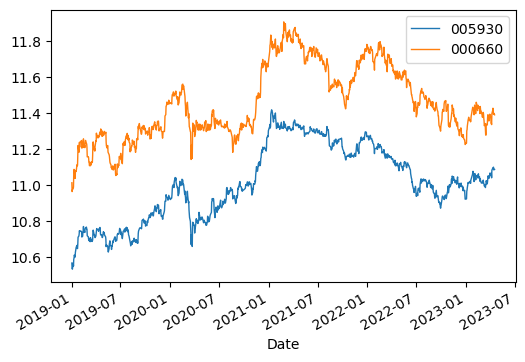

In [146]:
plt.figure(figsize = (6,4))
ax = plt.gca()
orig_data[stock1_name].plot(ax=ax,linewidth=1, fontsize=10)
orig_data[stock2_name].plot(ax=ax,linewidth=1, fontsize=10)
plt.legend()
plt.show()

In [141]:
dates = orig_data.index[:]; len(dates); dates
# dates = orig_data.index[-250:]; len(dates); dates

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2023-04-04', '2023-04-05', '2023-04-06', '2023-04-07',
               '2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13',
               '2023-04-14', '2023-04-17'],
              dtype='datetime64[ns]', name='Date', length=1061, freq=None)

In [142]:
betas0 = []

for date in tqdm(dates[:]):
    _data = orig_data.loc[:date]
    _stock1 = _data[stock1_name]
    _stock2 = _data[stock2_name]
    
    with pm.Model(coords={'time': _data.index.values}) as model:
        sigma_beta = pm.Exponential('sigma_beta', 50.0)
        beta = pm.GaussianRandomWalk('beta', sigma=sigma_beta, init_dist=pm.Normal.dist(0, 10), dims='time')
        
        regression = beta * _stock1
        sd = pm.HalfNormal('sd', sigma=0.1)
        likelihood = pm.Normal('y', mu=regression, sigma=sd, observed=_stock2)
        
        trace = pm.sample(draws=100, chains=1, cores=6, random_seed=0)
        
        _beta = trace.posterior['beta'].mean(dim=['draw', 'chain'])
        betas0.append(float(_beta[-1]))

  0%|          | 0/1061 [00:00<?, ?it/s]

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_beta, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.


KeyboardInterrupt: 

In [126]:
betas0

[0.9904669338820282,
 0.990819043235162,
 0.9910793268682313,
 0.9902209115065943,
 0.990093661305978,
 0.9904943806872498,
 0.9902759559268981,
 0.9901228064468077,
 0.9898210033353668,
 0.9899690589290515,
 0.9887675513299865,
 0.9889983168800253,
 0.9892666233672578,
 0.9896972911389019,
 0.989788376023156,
 0.9898426845484205,
 0.9894903700003148,
 0.9891578482751666,
 0.9891205628601771,
 0.988196254625194,
 0.9889879399360723,
 0.989163586091143,
 0.9894207562588155,
 0.9894983038143798,
 0.9897897743738854,
 0.9891961239964456,
 0.9894660076294535,
 0.9903011298637684,
 0.9909918492121388,
 0.9908842281480946,
 0.9905579573090237,
 0.9905641117822549,
 0.9907026158400147,
 0.9906812352025623,
 0.991163860165539,
 0.9910391430253,
 0.9915271879953049,
 0.9920687737043729,
 0.9927467132559794,
 0.9928626849497671,
 0.9925277846856043,
 0.9942069529999045,
 0.9932050994666858,
 0.9921241682744405,
 0.9916348273205406,
 0.9922245671576934,
 0.9914317982236502,
 0.9917661638712231,
 

In [89]:
betas5

[1.043525195354631,
 1.0441481071942436,
 1.0461441933317892,
 1.0461017236903694,
 1.0460493431465636,
 1.0450289693321375,
 1.0439546769437227,
 1.046597157766493,
 1.0462031680774782,
 1.0473147806964576,
 1.0461199283616913,
 1.044630672532535,
 1.043950893504097,
 1.043044216012697,
 1.0431985275879396,
 1.0438167284074455,
 1.0463817520969245,
 1.0468474228885125,
 1.0467865261846205,
 1.0473114067757103,
 1.0460135681629135,
 1.0458469663369885,
 1.0459092346516468,
 1.0447872877375637,
 1.045196266606302,
 1.0457138518350224,
 1.0441661641451276,
 1.043842384915938,
 1.0404733850282484,
 1.0418636901733374,
 1.0412004104354424,
 1.0423600678698748,
 1.0425509389741787,
 1.0424234197609223,
 1.041781296033055,
 1.0435914705405755,
 1.0434412293276596,
 1.043721156198935,
 1.0422911432917377,
 1.042649463546074,
 1.0433670339372072,
 1.0426183512887743,
 1.0433173084772671,
 1.0433800338762946,
 1.04435002790941,
 1.042835527356466,
 1.041340088589411,
 1.0410354714451082,
 1.043

In [97]:
betas6

[0.985495346877477,
 0.9861680674369392,
 0.9855167048657669,
 0.9861805169534013,
 0.9855439434168655,
 0.9846609810276952,
 0.9869181769357777,
 0.9848445966185172,
 0.9817664345306025,
 0.9866927321285327,
 0.9877366208582576,
 0.9886473850421903,
 0.9859616106653472,
 0.987487969988472,
 0.9871827878264098,
 0.9879869071797154,
 0.9873513567234348,
 0.9911577589452807,
 0.9887084846808457,
 0.989129492313359,
 0.9889821727670908,
 0.9881604643938385,
 0.9877157819640336,
 0.987742479509595,
 0.9920845549667259,
 0.9911730612126682,
 0.9936674124387995,
 0.9927658097519613,
 0.9934696093574017,
 0.9946195389793329,
 0.9966977872210747,
 1.0011878259532092,
 1.0001229153592102,
 1.002010676007269,
 1.0027500569642462,
 1.004565771121046,
 1.0043699035409763,
 1.003047190494405,
 1.0018031775414622,
 1.0045523421640596,
 1.004598571423808,
 1.0046705372447764,
 1.0030040387682306,
 1.0017911173871012,
 0.9995365696651423,
 1.0021208653697813,
 1.002523208697339,
 0.999165039257422,
 0

In [153]:
with pm.Model(coords={'time': orig_data.index.values}) as model:
    sigma_beta = pm.Exponential('sigma_beta', 50.0)
    sigma_alpha = pm.Exponential('sigma_alpha', 50.0)
    beta = pm.GaussianRandomWalk('beta', sigma=sigma_beta, init_dist=pm.Normal.dist(0, 10), dims='time')
    alpha = pm.GaussianRandomWalk('alpha', sigma=sigma_alpha, init_dist=pm.Normal.dist(0, 10), dims='time')

In [156]:
with model:
    regression = beta * stock1 + alpha
    sd = pm.HalfNormal('sd', sigma=0.1)
    likelihood = pm.Normal('y', mu=regression, sigma=sd, observed=stock2)

In [165]:
with model:
    trace_rw = pm.sample(draws=500, chains=2, cores=6, random_seed=0)
    #trace_rw = pm.sample(tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 6 jobs)
NUTS: [sigma_beta, sigma_alpha, beta, alpha, sd]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 195 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


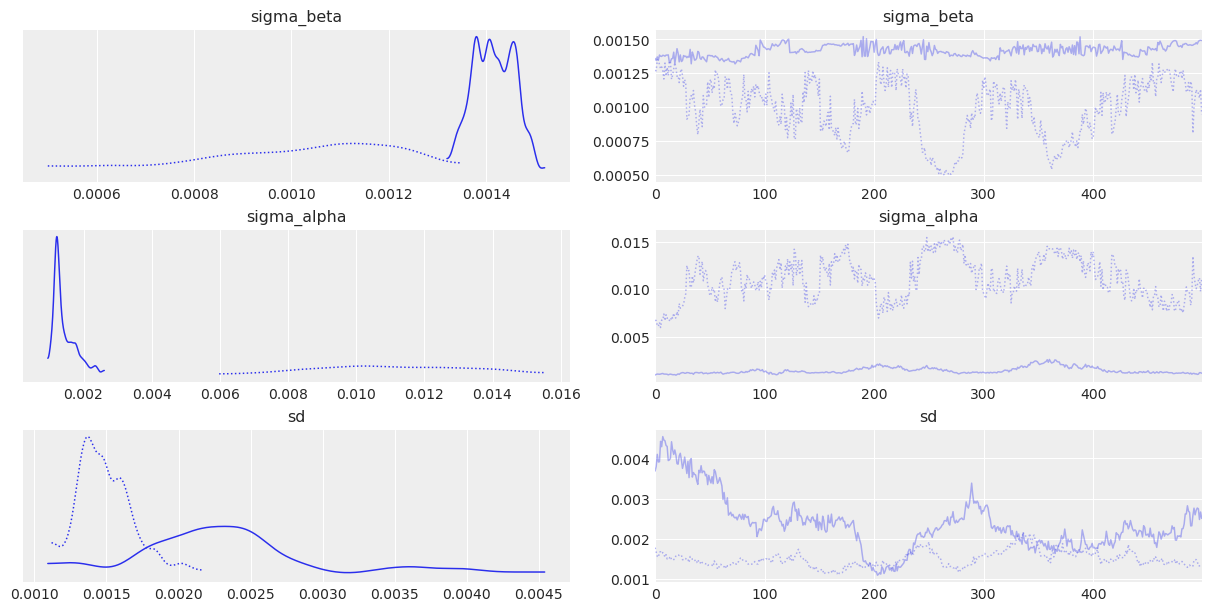

In [166]:
az.plot_trace(trace_rw, var_names=['sigma_beta', 'sigma_alpha', 'sd']);

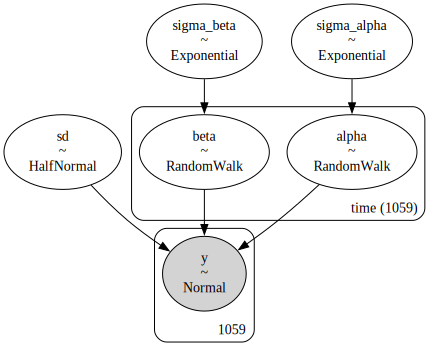

In [16]:
pm.model_to_graphviz(model)

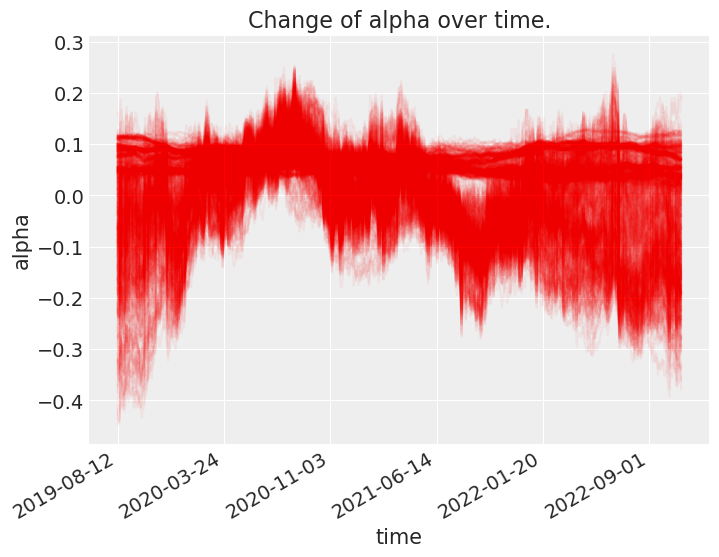

In [167]:
fig = plt.figure(figsize=(8, 6), constrained_layout=False)
ax = plt.subplot(111, xlabel="time", ylabel="alpha", title="Change of alpha over time.")
ax.plot(az.extract(trace_rw, var_names="alpha"), "r", alpha=0.05)

ticks_changes = mticker.FixedLocator(ax.get_xticks().tolist())
ticklabels_changes = [str(p.date()) for p in logp[::len(orig_data) // 7].index]
ax.xaxis.set_major_locator(ticks_changes)
ax.set_xticklabels(ticklabels_changes)

fig.autofmt_xdate()

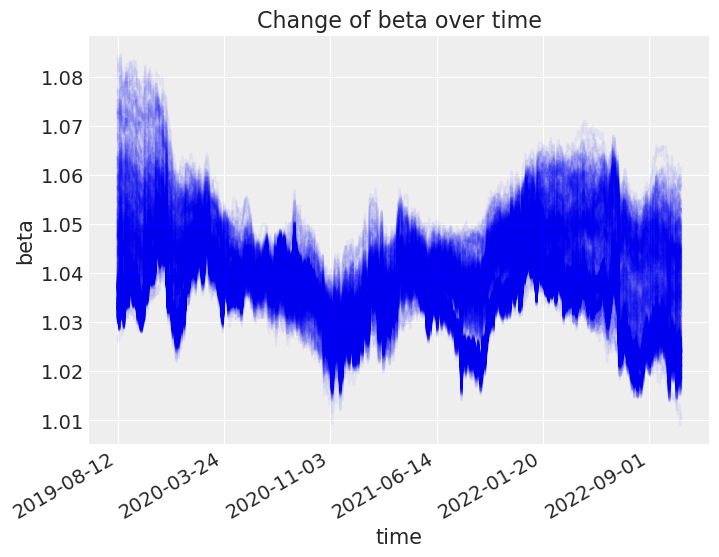

In [168]:
fig = plt.figure(figsize=(8, 6), constrained_layout=False)
ax = fig.add_subplot(111, xlabel="time", ylabel="beta", title="Change of beta over time")
ax.plot(az.extract(trace_rw, var_names="beta"), "b", alpha=0.05)

ticks_changes = mticker.FixedLocator(ax.get_xticks().tolist())
ticklabels_changes = [str(p.date()) for p in logp[::len(orig_data) // 7].index]

ax.xaxis.set_major_locator(ticks_changes)
ax.set_xticklabels(ticklabels_changes)

fig.autofmt_xdate()

<Axes: >

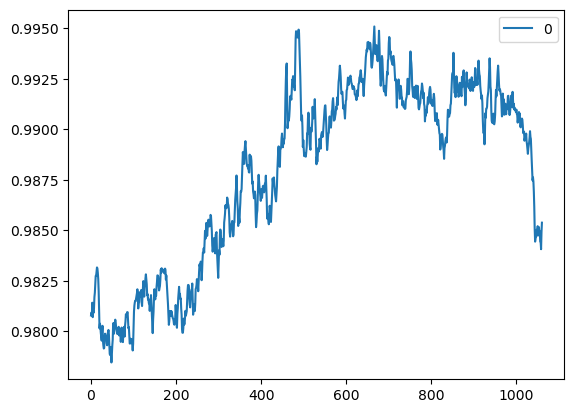

In [139]:
pd.DataFrame(betas0).plot()

In [135]:
#rolling_alpha = trace_rw.posterior['alpha'].mean(dim=['draw','chain'])
betas0 = trace_rw.posterior['beta'].mean(dim=['draw','chain'])

In [136]:
betas0

<xarray.DataArray 'beta' (time: 1061)>
array([0.98078594, 0.98092897, 0.98081266, ..., 0.98406748, 0.98491767,
       0.98538127])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-02 2019-01-03 ... 2023-04-17

In [129]:
def getStrategyPortfolioWeights(beta, stock_name1, stock_name2, data, smoothing_window=15):
    data1 = data[stock_name1]
    data2 = data[stock_name2]
    
    trading = "not"
    trading_start = 0
    leverage = 0*data.copy()
    
    signal_spot = pd.Series(np.zeros(data1.shape[0]), index=data.index)
    
    for i in range(smoothing_window, data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":
            # dynamically rebalance the signal when not trading
            fixed_beta = float(beta[i])
            #fixed_alpha = float(rolling_alpha[i])
            
            signal = fixed_beta*data1 - data2 #+ fixed_alpha
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()
            #thres = pd.Series(signal).rolling(5, min_periods=1).std()
            
            signal_spot[i] = smoothed_signal[i]

            if smoothed_signal[i] > 0 and d_smoothed_signal[i] < 0:
                w0 = -fixed_beta / (abs(fixed_beta)+1)
                w1 = 1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = np.sign(w0 / w_max)
                leverage.iloc[i,1] = np.sign(w1 / w_max)
                                
                trading = "short"
                trading_start = smoothed_signal[i]
                
            elif smoothed_signal[i] < 0 and d_smoothed_signal[i] > 0:
                w0 = fixed_beta / (abs(fixed_beta)+1)
                w1 = -1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = np.sign(w0 / w_max)
                leverage.iloc[i,1] = np.sign(w1 / w_max)
                                
                trading = "long"
                trading_start = smoothed_signal[i]
                
            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                
        elif trading=="long":
            # a failed trade
            if smoothed_signal[i] < trading_start:
            #if smoothed_signal[i] < -2*thres[i]:    
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] > 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
        elif trading=="short":
            signal_spot[i] = smoothed_signal[i]
            
            # a failed trade
            if smoothed_signal[i] > trading_start:
            #if smoothed_signal[i] > 2*thres[i]:    
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] < 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage.fillna(0), signal_spot

In [102]:
def backtest(pricingDF, openDF, leverageDF, start_cash):
    pricing = pricingDF.values
    pricing_open = openDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = cash[1] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    
    total_cost = 0
    pnl_hist = np.zeros(pricing.shape[0])
    pnl = []
    values = np.zeros(pricing.shape[0])
    values[0] = values[1] = start_cash

    
    for t in range(2, pricing.shape[0]):
        if np.any(leverage[t-1] != leverage[t-2]):
            target_shares = (start_cash * leverage[t-1] / pricing[t-1]).astype(int)
            
            # rebalance
            shares[t] = target_shares
            cost0 = abs(shares[t,0] - shares[t-1,0]) * pricing_open[t,0] * 0.0001
            #cost1 = abs(shares[t,1] - shares[t-1,1]) * pricing_open[t,1] * (0.00025 if shares[t,1] > shares[t-1,1] else 0.00225)
            cost1 = abs(shares[t,1] - shares[t-1,1]) * pricing_open[t,1] * 0.0001

            cash[t] = cash[t-1] - ((shares[t]-shares[t-1]) * pricing_open[t]).sum() - cost0 - cost1
            total_cost += (cost0 + cost1)
            
        else:
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
            
        values[t] = (shares[t] * pricing[t]).sum() + cash[t]
            
        if shares[t-1,0]==0 and shares[t,0]!=0:
            pnl_hist[t] = values[t] - values[t-1]
            
        elif shares[t,0]!=0 or (shares[t-1,0]!=0 and shares[t,0]==0):
            pnl_hist[t] = pnl_hist[t-1] + values[t] - values[t-1]
            
        if shares[t-1,0]!=0 and shares[t,0]==0:
            pnl.append(pnl_hist[t])
    
    
    pct_returns = (values - start_cash) / start_cash
    
    n_days = pct_returns.shape[0]
    net_profit = int(values[-1] - start_cash)
    net_return = pct_returns[-1] * 100
    total_cost_rate = total_cost / (net_profit + total_cost) * 100
    n_entry = len(pnl)
    n_entry_monthly = n_entry / n_days * 20
    n_entry_days = (leverageDF.iloc[:,0] != 0).sum()
    n_holding_days = n_entry_days / n_entry
    pnl_by_entry = net_profit / n_entry
    profit_of_profit_entry = np.mean(list(filter(lambda x: x>0, pnl)))
    loss_of_loss_entry = np.mean(list(filter(lambda x: x<0, pnl)))
    pnl = pd.Series(pnl)
    hit_ratio = sum(pnl>0) / len(pnl) * 100
    #set_trace()

    print(f'테스트 일수: {n_days}일')
    print(f'순손익 (투자금액대비%): {format(net_profit, ",")}원 ({net_return:.3f}%)')
    print(f'총비용 (총손익대비%): {format(int(total_cost), ",")}원 ({total_cost_rate:.3f}%)')
    print(f'진입횟수: {n_entry}회')
    print(f'월평균 진입횟수: {n_entry_monthly:.2f}회')
    print(f'진입일수 (전체일수대비%): {n_entry_days}일 ({n_entry_days/n_days*100:.2f}%)')
    print(f'평균보유일수: {n_holding_days:.2f}일')
    print(f'진입당 평균손익: {format(int(pnl_by_entry), ",")}원')
    print(f'최대수익: {format(int(max(pnl)), ",")}원')
    print(f'최대손실: {format(int(min(pnl)), ",")}원')
    print(f'수익진입의 평균수익: {format(int(profit_of_profit_entry), ",")}원')
    #print(f'손실진입의 평균손실: {format(int(loss_of_loss_entry), ",")}원')
    print(f'승률: {hit_ratio:.2f}%')
    
    return (
        pd.DataFrame(shares, index=pricingDF.index, columns=pricingDF.columns),
        pd.Series(cash, index=pricingDF.index),
        pd.Series(pct_returns, index=pricingDF.index),
        pd.Series(values, index=pricingDF.index),
        pd.Series(pnl_hist, index=pricingDF.index),
        pnl
    )

테스트 일수: 1061일
순손익 (투자금액대비%): 41,216,251원 (41.216%)
총비용 (총손익대비%): 4,120,498원 (9.089%)
진입횟수: 103회
월평균 진입횟수: 1.94회
진입일수 (전체일수대비%): 106일 (9.99%)
평균보유일수: 1.03일
진입당 평균손익: 400,157원
최대수익: 3,138,006원
최대손실: -1,393,860원
수익진입의 평균수익: 798,226원
승률: 69.90%


<Axes: xlabel='Date'>

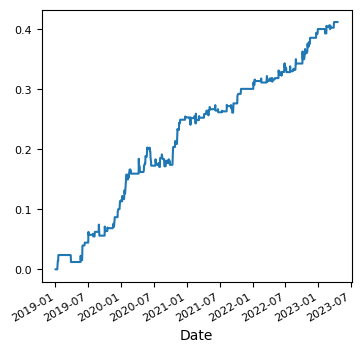

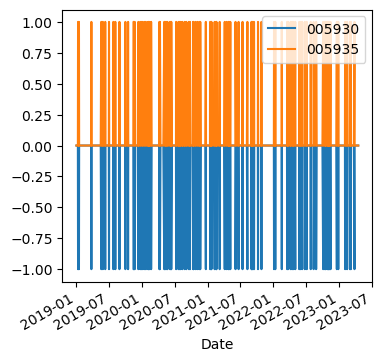

In [137]:
w0, signal0 = getStrategyPortfolioWeights(betas0, stock1_name, stock2_name, orig_data[:], smoothing_window=1)
shares0, cash0, returns0, values0, pnl_hist0, pnl0 = backtest(p_data[:], p_open_data[:], w0, 1e8)
returns0.plot(figsize=(4,4), fontsize=8)
w0.plot(figsize=(4,4), fontsize=10)

테스트 일수: 1059일
순손익 (투자금액대비%): 276,343,768원 (276.344%)
총비용 (총손익대비%): 9,352,581원 (3.274%)
진입횟수: 233회
월평균 진입횟수: 4.40회
진입일수 (전체일수대비%): 235일 (22.19%)
평균보유일수: 1.01일
진입당 평균손익: 1,186,024원
최대수익: 9,793,844원
최대손실: -2,376,675원
수익진입의 평균수익: 1,664,611원
손실진입의 평균손실: -598,069원


<Axes: xlabel='Date'>

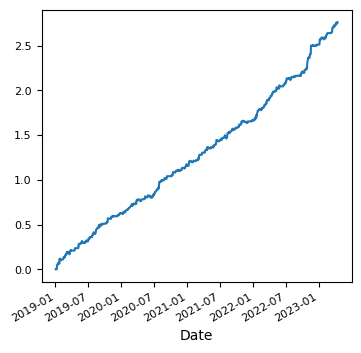

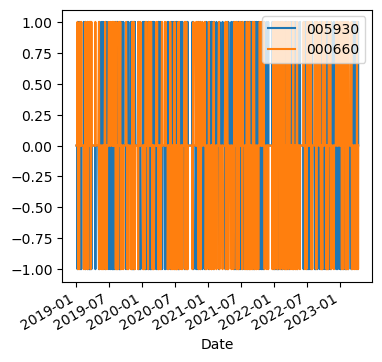

In [44]:
w5, signal5 = getStrategyPortfolioWeights(beta, stock1_name, stock2_name, orig_data, smoothing_window=1)
shares5, cash5, returns5, values5, pnl_hist5, pnl5 = backtest(p_data, p_open_data, w5, 1e8)
returns5.plot(figsize=(4,4), fontsize=8)
w5.plot(figsize=(4,4), fontsize=10)

테스트 일수: 250일
순손익 (투자금액대비%): 26,462,036원 (26.462%)
총비용 (총손익대비%): 1,441,363원 (5.166%)
진입횟수: 36회
월평균 진입횟수: 2.88회
진입일수 (전체일수대비%): 36일 (14.40%)
평균보유일수: 1.00일
진입당 평균손익: 735,056원
최대수익: 9,793,844원
최대손실: -2,291,288원
수익진입의 평균수익: 1,844,347원
승률: 61.11%


<Axes: xlabel='Date'>

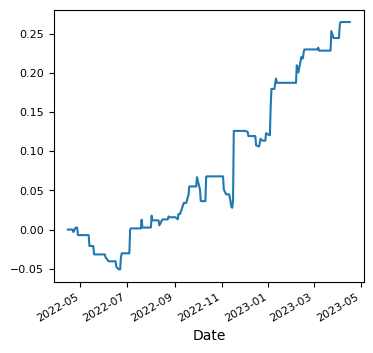

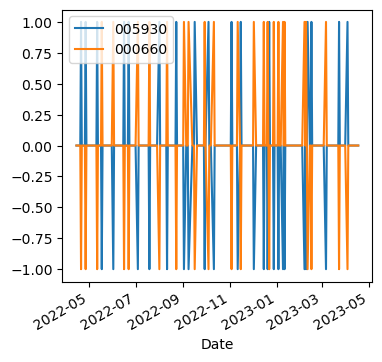

In [91]:
w5, signal5 = getStrategyPortfolioWeights(betas5, stock1_name, stock2_name, orig_data[-250:], smoothing_window=1)
shares5, cash5, returns5, values5, pnl_hist5, pnl5 = backtest(p_data[-250:], p_open_data[-250:], w5, 1e8)
returns5.plot(figsize=(4,4), fontsize=8)
w5.plot(figsize=(4,4), fontsize=10)

In [113]:
w6, signal6 = getStrategyPortfolioWeights(betas6, stock1_name, stock2_name, orig_data[-250:], smoothing_window=1)
shares6, cash6, returns6, values6, pnl_hist6, pnl6 = backtest(p_data[-250:], p_open_data[-250:], w6, 1e8)
returns6.plot(figsize=(4,4), fontsize=8)
w6.plot(figsize=(4,4), fontsize=10)

테스트 일수: 250일
순손익 (투자금액대비%): 13,742,829원 (13.743%)
총비용 (총손익대비%): 380,670원 (2.695%)
진입횟수: 9회
월평균 진입횟수: 0.72회
진입일수 (전체일수대비%): 234일 (93.60%)
평균보유일수: 26.00일
진입당 평균손익: 1,526,981원
최대수익: -113,769원
최대손실: -3,152,770원


C:\ProgramData\Anaconda3\envs\pymc_env\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\envs\pymc_env\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

테스트 일수: 1061일
순손익 (투자금액대비%): 48,813,932원 (48.814%)
총비용 (총손익대비%): 13,052,067원 (21.097%)
진입횟수: 326회
월평균 진입횟수: 6.15회
진입일수 (전체일수대비%): 335일 (31.57%)
평균보유일수: 1.03일
진입당 평균손익: 149,735원
최대수익: 8,506,656원
최대손실: -7,441,516원
수익진입의 평균수익: 1,766,404원
승률: 50.92%


<Axes: xlabel='Date'>

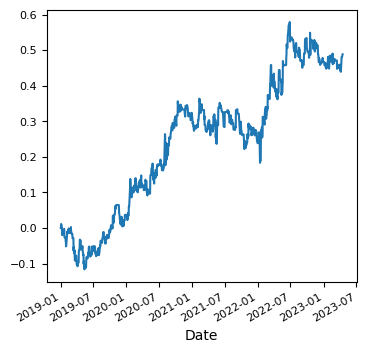

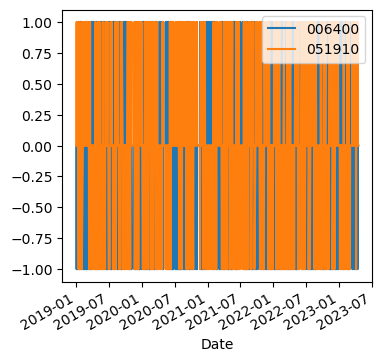

In [120]:
w6, signal6 = getStrategyPortfolioWeights(betas6, stock1_name, stock2_name, orig_data, smoothing_window=1)
shares6, cash6, returns6, values6, pnl_hist6, pnl6 = backtest(p_data, p_open_data, w6, 1e8)
returns6.plot(figsize=(4,4), fontsize=8)
w6.plot(figsize=(4,4), fontsize=10)

In [117]:
betas6.shape

(1061,)